## Strategies to Think about

- 1st derivative analysis of peaks to determine when to sell and buy
- Fast fourier transform to estimate harmonic osscilations in the market over short timespans
- Rolling averages, seem to be widely use
- Explore machine learning algorithms


In [56]:
# Standard Library Imports
from datetime import datetime, timedelta

# Third party Imports
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.linalg import solve
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from scipy.optimize import minimize
from scipy.signal import savgol_filter

# Alpaca Imports
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical import CryptoHistoricalDataClient

## Investment Data and information


In [57]:
# Time Specifications for data
resolution = 10  # minutes
time_frame = TimeFrame(resolution, TimeFrameUnit("Min"))
time_length = 10  # days
start_time = datetime.now() - timedelta(days=time_length)
end_time = datetime.now()

symbols = ["BTC/USD"]

investment = 10000  # dollars
initial_investment = investment

## API call for current and historic data


In [58]:
# No keys required for crypto data
client = CryptoHistoricalDataClient()

# Creating request object
request_params = CryptoBarsRequest(
    symbol_or_symbols=symbols,
    timeframe=time_frame,
    start=start_time,
    end=end_time,
)

# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)

# Convert to dataframe
btc_data = btc_bars.df.reset_index()

In [59]:
# fig = go.Figure(
#     data=[go.Candlestick(x=btc_data['timestamp'],
#     open=btc_data['open'],
#     high=btc_data['high'],
#     low=btc_data['low'],
#     close=btc_data['close'])]
# )

# fig.update_layout(
#     width=1500,  # Set the width in pixels
#     height=600 # Set the height in pixels
# )

# fig.update_layout(
#     title={
#         'text': f"Candlestick Plot with {resolution} minute Resolution, Starting on {start_time.strftime('%Y-%m-%d %H:%M')}",
#         'x': 0.5,
#         'xanchor': 'center',
#         'y': 0.9,
#         'yanchor': 'top'
#     }
# )

# fig.show()

### First Derivative of market data


In [60]:
first_deriv = savgol_filter(btc_data["close"], window_length=60, polyorder=3, deriv=1)
btc_data["First Derivative"] = first_deriv

In [61]:
# fig = px.line(btc_data, x='timestamp', y='First Derivative')
# fig.update_layout(
#     title={
#         'text': f"First Derivative Plot with {resolution} minute Resolution, Starting on {start_time.strftime('%Y-%m-%d %H:%M')}",
#         'x': 0.5,
#         'xanchor': 'center',
#         'y': 0.9,
#         'yanchor': 'top'
#     }
# )
# fig.show()

In [62]:
def one_sided_savitzky_golay(y, window_length, polyorder, deriv=0):
    """
    Applies a one-sided Savitzky-Golay filter to the input array.

    Args:
        y (np.ndarray): The input array to filter.
        window_length (int): The size of the filter window (must be odd).
        polyorder (int): The polyorder of the polynomial to fit.
        deriv (int, optional): The polyorder of the deriv to compute 
                                     (default is 0 for smoothing).

    Returns:
        np.ndarray: The filtered array or deriv.
    """
    if window_length % 2 != 1 or window_length < 1:
        raise ValueError("Window size must be a positive odd number")
    if window_length < polyorder + 1:
        raise ValueError("Window size is too small for the polynomial polyorder")

    half_window = (window_length - 1) // 2
    
    # Construct the Vandermonde design matrix
    x = np.arange(window_length)
    V = np.stack([x**i for i in range(polyorder + 1)], axis=1)
    
    # Calculate filter coefficients
    try:
        coeffs = solve(V.T @ V, V.T)
    except np.linalg.LinAlgError:
         raise ValueError("Singular matrix: try decreasing polynomial polyorder or window size")

    # Extract the deriv coefficients
    if deriv > polyorder:
        raise ValueError("deriv polyorder is too high for the polynomial polyorder")
    
    deriv_coeffs = coeffs[deriv]
    
    # Apply the filter to each point, considering the one-sided window
    filtered_values = np.zeros_like(y)
    for i in range(len(y)):
        start = max(0, i - window_length + 1)
        end = i + 1
        window = y[start:end]
        
        if len(window) < window_length:
            pad_size = window_length - len(window)
            padded_window = np.pad(window, (pad_size, 0), 'edge')
            filtered_values[i] = np.dot(deriv_coeffs, padded_window)
        else:
            filtered_values[i] = np.dot(deriv_coeffs, window)
            
    return filtered_values

## Mean Reversion Strategy


In [63]:
first_resolution = 0.5*int(60 / resolution) * 24  # minute
second_resolution = 3 * int(60 / resolution) * 24  # minute

btc_data["Moving Avg (Hour)"] = btc_data["close"].rolling(int(first_resolution)).mean()
btc_data["Moving Avg (Hour) STD"] = btc_data["close"].rolling(int(first_resolution)).std()
btc_data["Moving Avg (Hour) Deriv"] = one_sided_savitzky_golay(
    btc_data["Moving Avg (Hour)"], window_length=15, polyorder=2, deriv=2
)

btc_data["Moving Avg (Day)"] = btc_data["close"].rolling(second_resolution).mean()
btc_data["Moving Avg (Day) STD"] = btc_data["close"].rolling(second_resolution).std()

In [64]:
len(btc_data)

1438

In [65]:
def mean_reversion_crypto_algo(data: pd.DataFrame, investment, deriv_cutoff):
    orders_dict = {}
    sub_data_dict = {}
    current_key = 0
    has_position = False

    most_profitable_trade_datetime = ""
    most_profitable_trade_amount = -np.inf

    most_unprofitable_trade_datetime = ""
    most_unprofitable_trade_amount = np.inf

    win_len = 3

    

    first_resolution = 0.5*int(60 / resolution) * 24  # minute
    second_resolution = 3 * int(60 / resolution) * 24  # minute

    

    for idx in range(len(data)):

        if idx-1 < win_len:
            continue

        sub_data = data.iloc[:idx-1, :].copy()

        sub_data["Moving Avg (Hour)"] = sub_data["close"].rolling(int(first_resolution)).mean()
        sub_data["Moving Avg (Hour) STD"] = sub_data["close"].rolling(int(first_resolution)).std()
        sub_data["Moving Avg (Hour) Deriv"] = savgol_filter(
            sub_data["Moving Avg (Hour)"], window_length=win_len, polyorder=2, deriv=2
        )

        sub_data["Moving Avg (Day)"] = sub_data["close"].rolling(second_resolution).mean()
        sub_data["Moving Avg (Day) STD"] = sub_data["close"].rolling(second_resolution).std()
        
        row = sub_data.iloc[idx-win_len, :]


        if np.isnan(row["Moving Avg (Day)"]):
            continue

        if (
            (row["Moving Avg (Hour)"] > row["Moving Avg (Day)"])
            and not has_position
            and (row["Moving Avg (Hour) Deriv"] > 0)
        ):
            has_position = True
            orders_dict[current_key] = {
                "First Deriv at Purchase": row["Moving Avg (Hour) Deriv"],
                "Order Index": idx-win_len,
                "Order Datetime": row["timestamp"],
                "Order Price": row["close"],
            }

        if has_position:
            if (
                row["Moving Avg (Hour) Deriv"]
                < -orders_dict[current_key]["First Deriv at Purchase"] * deriv_cutoff
            ):
                orders_dict[current_key]["First Deriv at Sell"] = row[
                    "Moving Avg (Hour) Deriv"
                ]
                orders_dict[current_key]["Sell Datetime"] = row["timestamp"]
                orders_dict[current_key]["Sell Price"] = row["close"]
                orders_dict[current_key]["Percent Change"] = (
                    100
                    * (row["close"] - orders_dict[current_key]["Order Price"])
                    / orders_dict[current_key]["Order Price"]
                )
                orders_dict[current_key]["Profit"] = (
                    orders_dict[current_key]["Percent Change"] * investment / 100
                )
                investment += orders_dict[current_key]["Profit"]

                if orders_dict[current_key]["Profit"] > most_profitable_trade_amount:
                    most_profitable_trade_amount = orders_dict[current_key]["Profit"]
                    most_profitable_trade_datetime = orders_dict[current_key][
                        "Order Datetime"
                    ]
                if orders_dict[current_key]["Profit"] < most_unprofitable_trade_amount:
                    most_unprofitable_trade_amount = orders_dict[current_key]["Profit"]
                    most_unprofitable_trade_datetime = orders_dict[current_key][
                        "Order Datetime"
                    ]

                sub_data_dict[idx] = sub_data
                has_position = False
                if orders_dict[current_key]["Profit"] != 0:
                    current_key += 1

    trade_metrics = [
        most_profitable_trade_datetime,
        most_profitable_trade_amount,
        most_unprofitable_trade_datetime,
        most_unprofitable_trade_amount,
    ]
    return orders_dict, trade_metrics, investment, sub_data_dict


orders_dict, trade_metrics, investment, sub_data_ = mean_reversion_crypto_algo(
    btc_data, investment, deriv_cutoff=0.15
)

total_profit = investment - initial_investment
profit_per_day = (investment - initial_investment) / time_length
percent_profit_per_day = total_profit / initial_investment / time_length


print("Trading Results Summary")
print("------------------------------")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Profit/Day: ${profit_per_day:,.2f}")
print(f"Percent Profit/Day: {100 * percent_profit_per_day:,.3f}%")
print(f"Final Investment: ${investment:,.2f}")
print("------------------------------")
print(
    f"Most Profitable Trade: ${trade_metrics[1]:,.2f}, Order Date: {trade_metrics[0]}"
)
print(
    f"Most Un-Profitable Trade: ${trade_metrics[3]:,.2f}, Order Date: {trade_metrics[2]}"
)


Trading Results Summary
------------------------------
Total Profit: $3,387.24
Profit/Day: $338.72
Percent Profit/Day: 3.387%
Final Investment: $13,387.24
------------------------------
Most Profitable Trade: $224.13, Order Date: 2025-03-19 18:20:00+00:00
Most Un-Profitable Trade: $-36.07, Order Date: 2025-03-18 04:00:00+00:00


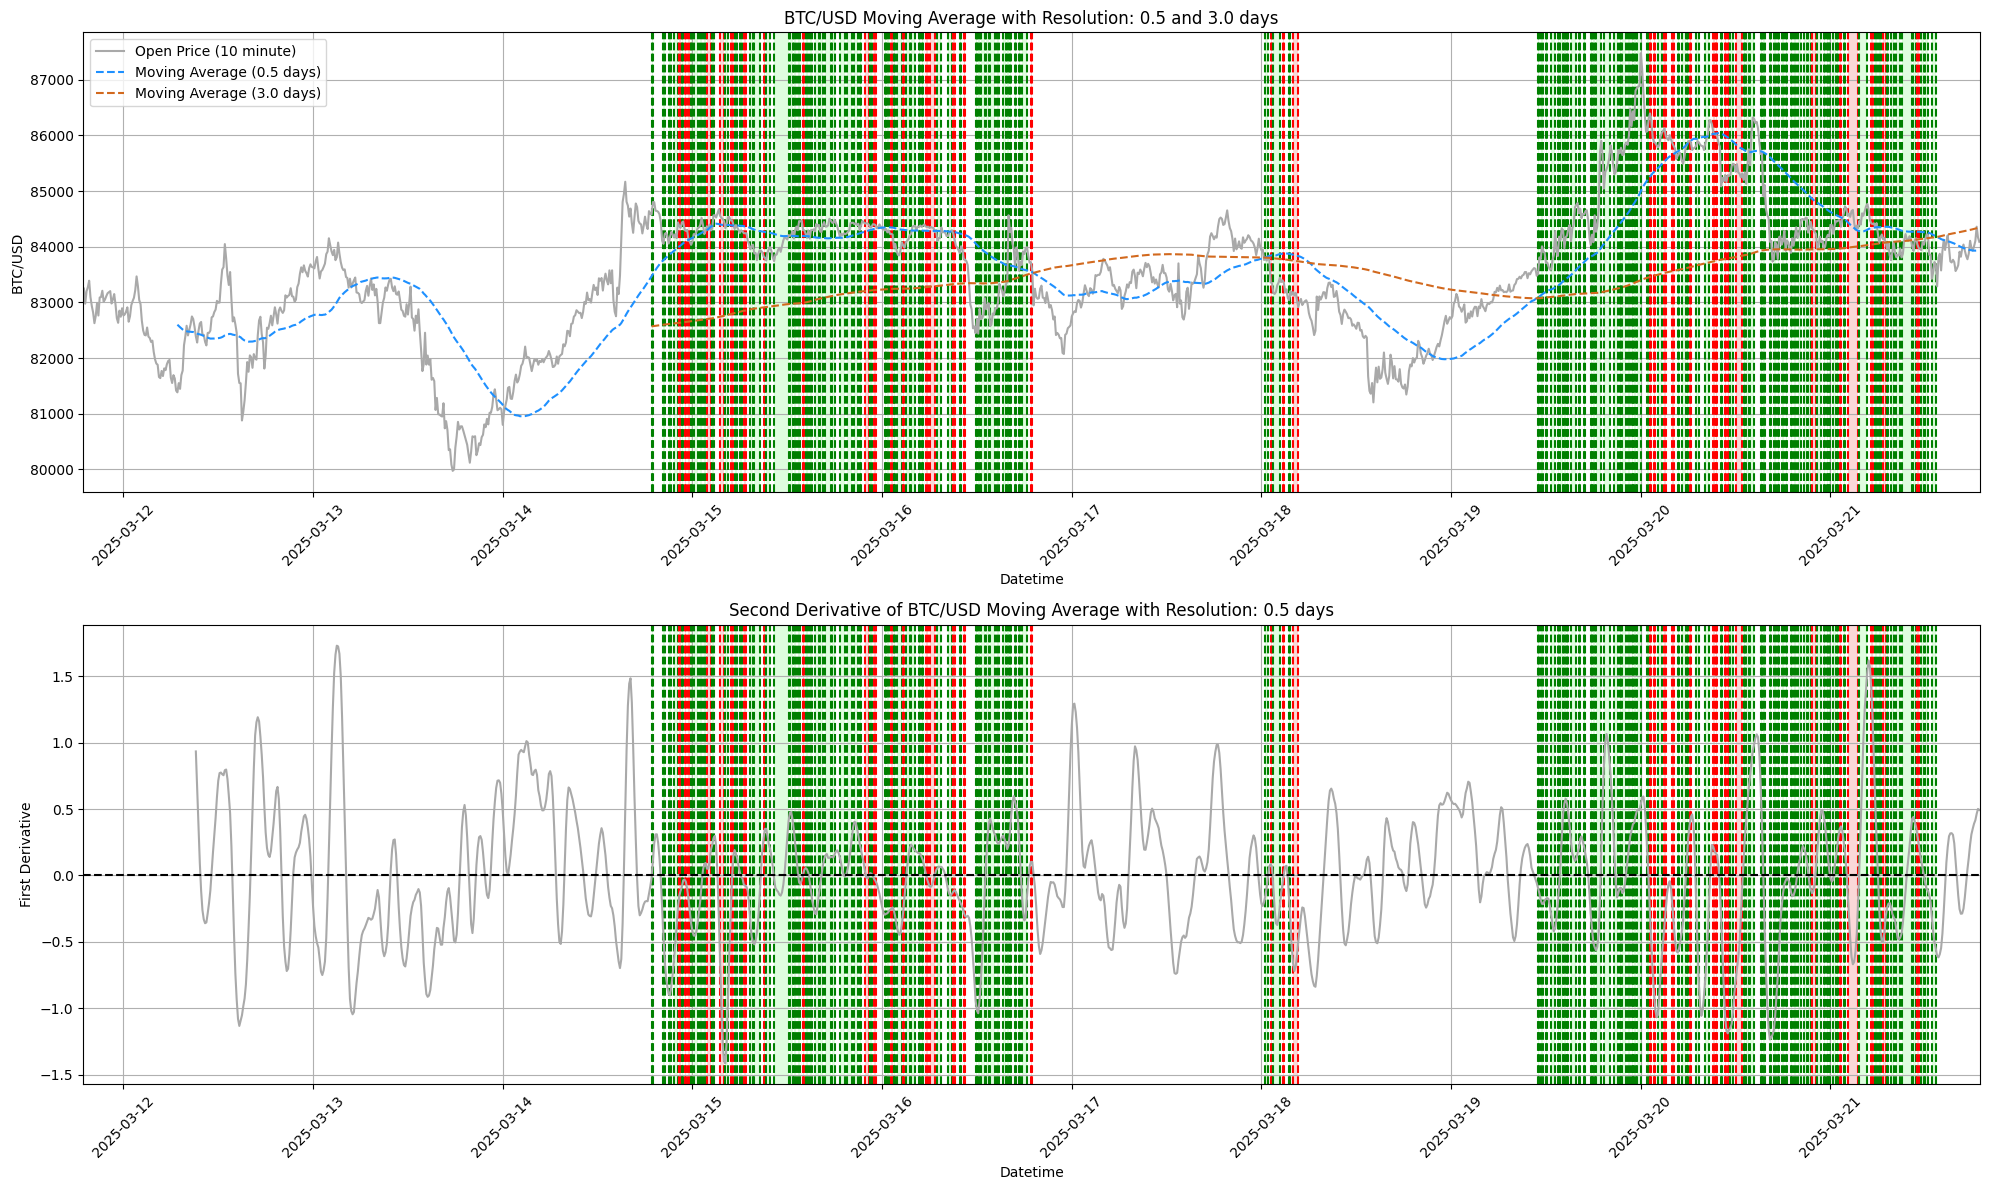

In [77]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

for key, data in orders_dict.items():
    try:
        if data["Profit"] >= 0:
            ax[0].axvline(data["Order Datetime"], linestyle="--", c="green")
            ax[1].axvline(data["Order Datetime"], linestyle="--", c="green")
            ax[0].axvline(data["Sell Datetime"], linestyle="--", c="green")
            ax[1].axvline(data["Sell Datetime"], linestyle="--", c="green")
            ax[0].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="palegreen",
                alpha=0.3,
            )
            ax[1].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="palegreen",
                alpha=0.3,
            )
        else:
            ax[0].axvline(data["Order Datetime"], linestyle="--", c="red")
            ax[1].axvline(data["Order Datetime"], linestyle="--", c="red")
            ax[0].axvline(data["Sell Datetime"], linestyle="--", c="red")
            ax[1].axvline(data["Sell Datetime"], linestyle="--", c="red")
            ax[0].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="lightcoral",
                alpha=0.3,
            )
            ax[1].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="lightcoral",
                alpha=0.3,
            )
    except KeyError:
        ax[0].axvline(data["Order Datetime"], linestyle="--", c="green")
        ax[1].axvline(data["Order Datetime"], linestyle="--", c="green")


ax[0].plot(
    btc_data["timestamp"],
    btc_data["close"],
    c="darkgray",
    label=f"Open Price ({resolution} minute)",
)

ax[0].plot(
    btc_data["timestamp"],
    btc_data["Moving Avg (Hour)"],
    c="dodgerblue",
    linestyle="--",
    label=f"Moving Average ({first_resolution / (int(60 / resolution) * 24)} days)",
)
# ax[0].plot(btc_data["timestamp"], btc_data["Moving Avg (Hour)"]+ 2*btc_data["Moving Avg (Hour) STD"], c="lightcoral", linestyle="--", label=f"STD High ({first_resolution/(int(60/resolution)*24)} days)")
# ax[0].plot(btc_data["timestamp"], btc_data["Moving Avg (Hour)"]- 2*btc_data["Moving Avg (Hour) STD"], c="lightcoral", linestyle="--", label=f"STD Low ({first_resolution/(int(60/resolution)*24)} days)")

ax[0].plot(
    btc_data["timestamp"],
    btc_data["Moving Avg (Day)"],
    c="chocolate",
    linestyle="--",
    label=f"Moving Average ({second_resolution / (int(60 / resolution) * 24)} days)",
)
# ax[0].plot(btc_data["timestamp"], btc_data["Moving Avg (Day)"]+ 2*btc_data["Moving Avg (Day) STD"], c="palegreen", linestyle="--", label=f"STD High ({second_resolution/(int(60/resolution)*24)} days)")
# ax[0].plot(btc_data["timestamp"], btc_data["Moving Avg (Day)"]- 2*btc_data["Moving Avg (Day) STD"], c="palegreen", linestyle="--", label=f"STD Low ({second_resolution/(int(60/resolution)*24)} days)")

ax[0].grid()
ax[0].legend()
ax[0].set_xlim(start_time, end_time)
ax[0].set_xlabel("Datetime")
ax[0].set_ylabel(f"{symbols[0]}")
ax[0].set_title(
    f"{symbols[0]} Moving Average with Resolution: {first_resolution / (int(60 / resolution) * 24)} and {second_resolution / (int(60 / resolution) * 24)} days"
)
axis_interval = int(time_length/20) if time_length/20 > 1  else 1
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[0].tick_params(axis="x", labelrotation=45)


ax[1].plot(
    btc_data["timestamp"],
    btc_data["Moving Avg (Hour) Deriv"],
    c="darkgray",
    label=f"Moving Average ({first_resolution / (int(60 / resolution) * 24)} days)",
)
ax[1].axhline(0, linestyle="--", c="k")

ax[1].grid()
ax[1].set_xlim(start_time, end_time)
ax[1].set_xlabel("Datetime")
ax[1].set_ylabel("First Derivative")
ax[1].set_title(
    f"Second Derivative of {symbols[0]} Moving Average with Resolution: {first_resolution / (int(60 / resolution) * 24)} days"
)
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[1].tick_params(axis="x", labelrotation=45)

fig.tight_layout()

In [67]:
start_time <end_time

True

KeyError: 437

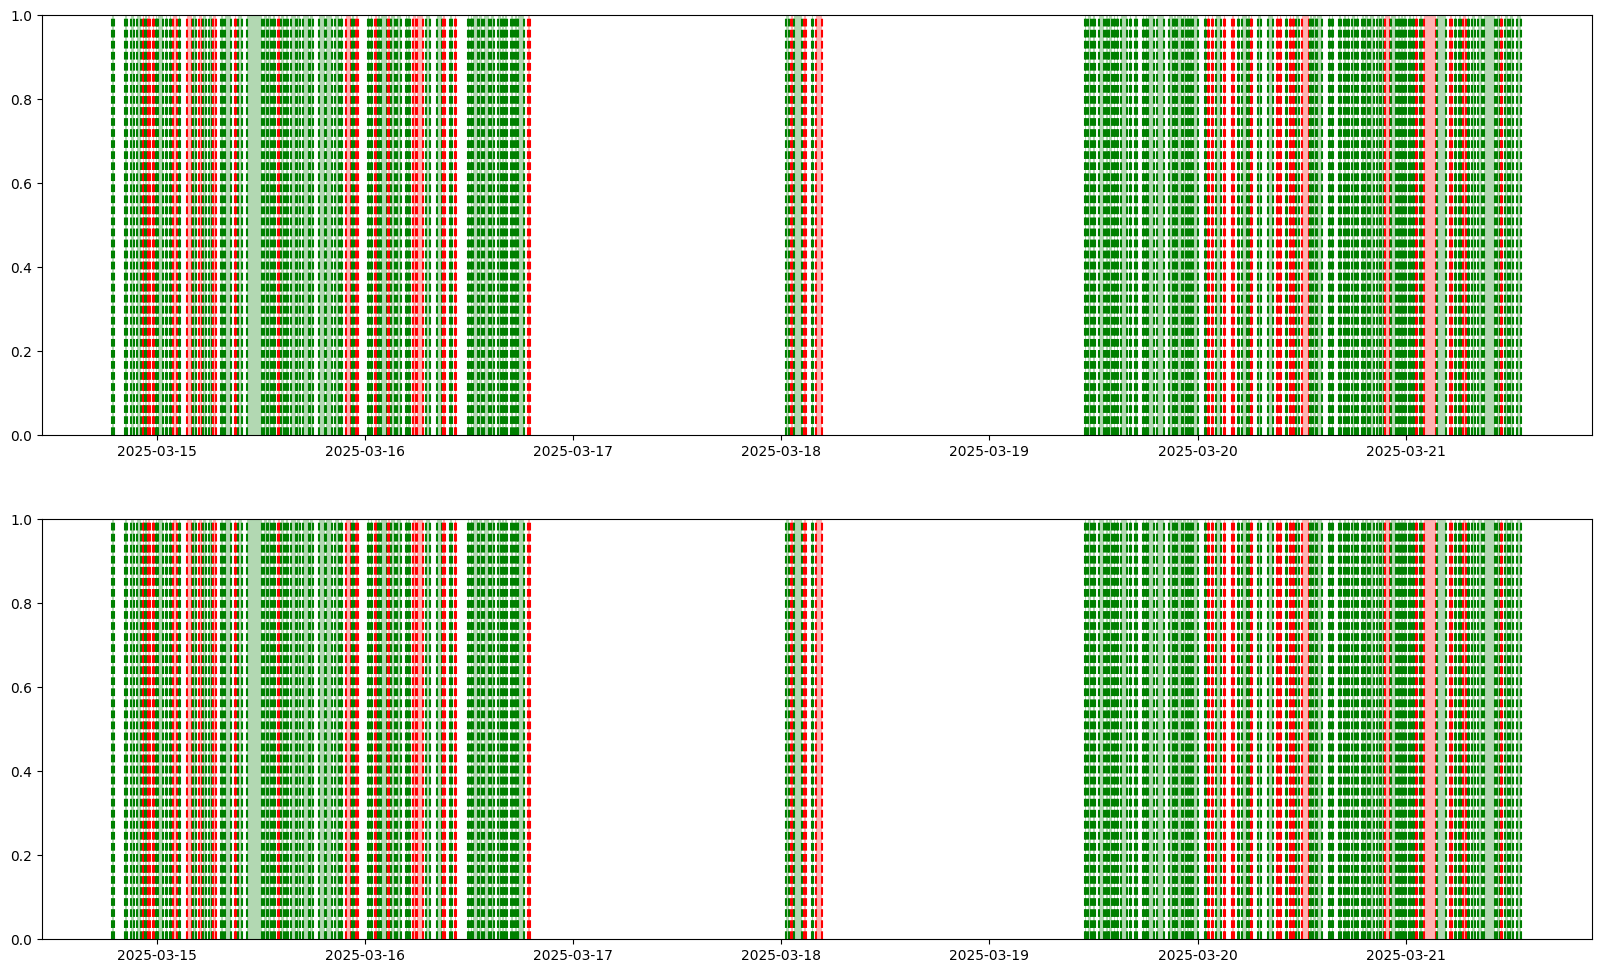

In [68]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

for key, data in orders_dict.items():
    try:
        if data["Profit"] >= 0:
            ax[0].axvline(data["Order Datetime"], linestyle="--", c="g")
            ax[1].axvline(data["Order Datetime"], linestyle="--", c="g")
            ax[0].axvline(data["Sell Datetime"], linestyle="--", c="g")
            ax[1].axvline(data["Sell Datetime"], linestyle="--", c="g")
            ax[0].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="g",
                alpha=0.3,
            )
            ax[1].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="g",
                alpha=0.3,
            )
        else:
            ax[0].axvline(data["Order Datetime"], linestyle="--", c="r")
            ax[1].axvline(data["Order Datetime"], linestyle="--", c="r")
            ax[0].axvline(data["Sell Datetime"], linestyle="--", c="r")
            ax[1].axvline(data["Sell Datetime"], linestyle="--", c="r")
            ax[0].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="r",
                alpha=0.3,
            )
            ax[1].axvspan(
                data["Order Datetime"],
                data["Sell Datetime"],
                linestyle="--",
                facecolor="r",
                alpha=0.3,
            )
    except KeyError:
        ax[0].axvline(data["Order Datetime"], linestyle="--", c="g")
        ax[1].axvline(data["Order Datetime"], linestyle="--", c="g")


ax[0].plot(
    sub_data_[437]["timestamp"],
    sub_data_[437]["close"],
    c="cornflowerblue",
    label=f"Open Price ({resolution} minute)",
)

ax[0].plot(
    sub_data_[437]["timestamp"],
    sub_data_[437]["Moving Avg (Hour)"],
    c="red",
    linestyle="--",
    label=f"Moving Average ({first_resolution / (int(60 / resolution) * 24)} days)",
)

ax[0].plot(
    sub_data_[437]["timestamp"],
    sub_data_[437]["Moving Avg (Day)"],
    c="lime",
    linestyle="--",
    label=f"Moving Average ({second_resolution / (int(60 / resolution) * 24)} days)",
)

ax[0].grid()
ax[0].legend()
# ax[0].set_xlim(sub_data_[437]["timestamp"].iloc[0], sub_data_[437]["timestamp"].iloc[-1])
ax[0].set_xlim(orders_dict[0]['Order Datetime'], orders_dict[0]['Sell Datetime'])
ax[0].set_xlabel("Datetime")
ax[0].set_ylabel(f"{symbols[0]}")
ax[0].set_title(
    f"{symbols[0]} Moving Average with Resolution: {first_resolution / (int(60 / resolution) * 24)} and {second_resolution / (int(60 / resolution) * 24)} days"
)
axis_interval = int(time_length/20) if time_length/20 > 0  else 1
# ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[0].tick_params(axis="x", labelrotation=45)


ax[1].plot(
    sub_data_[437]["timestamp"],
    sub_data_[437]["Moving Avg (Hour) Deriv"],
    c="cornflowerblue",
    label=f"Moving Average ({first_resolution / (int(60 / resolution) * 24)} days)",
)
ax[1].axhline(0, linestyle="--", c="k")

ax[1].grid()
# ax[1].set_xlim(sub_data_[437]["timestamp"].iloc[0], sub_data_[437]["timestamp"].iloc[-1])
ax[1].set_xlim(orders_dict[0]['Order Datetime'], orders_dict[0]['Sell Datetime'])
ax[1].set_xlabel("Datetime")
ax[1].set_ylabel("First Derivative")
ax[1].set_title(
    f"Second Derivative of {symbols[0]} Moving Average with Resolution: {first_resolution / (int(60 / resolution) * 24)} days"
)
# ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=axis_interval))
ax[1].tick_params(axis="x", labelrotation=45)

fig.tight_layout()

In [ ]:
sub_data_[437]

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,First Derivative,Moving Avg (Hour),Moving Avg (Hour) STD,Moving Avg (Hour) Deriv,Moving Avg (Day),Moving Avg (Day) STD
0,BTC/USD,2025-03-11 18:10:00+00:00,81952.9000,82443.1270,81952.900000,82284.9525,0.105914,9.0,82308.320347,10.821002,NaN,NaN,NaN,NaN,NaN
1,BTC/USD,2025-03-11 18:20:00+00:00,82231.7060,82813.5445,82137.078376,82504.0850,0.149930,6.0,82748.283418,11.051931,NaN,NaN,NaN,NaN,NaN
2,BTC/USD,2025-03-11 18:30:00+00:00,82490.8665,82679.3230,82372.390000,82551.0450,0.015741,4.0,82637.394913,11.231804,NaN,NaN,NaN,NaN,NaN
3,BTC/USD,2025-03-11 18:40:00+00:00,82594.5400,83019.2375,82565.870000,83019.2375,0.001229,2.0,82918.574324,11.360621,NaN,NaN,NaN,NaN,NaN
4,BTC/USD,2025-03-11 18:50:00+00:00,82986.0365,83513.6000,82939.015500,83276.8650,0.003037,4.0,83471.799668,11.438381,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,BTC/USD,2025-03-14 18:00:00+00:00,84408.9790,84600.3335,84408.979000,84541.2000,0.000000,0.0,84437.292000,-8.470208,83290.024486,906.245477,-0.777354,82549.966402,1003.386580
432,BTC/USD,2025-03-14 18:10:00+00:00,84583.0735,84668.3455,84377.896000,84397.8690,0.008036,2.0,84492.196532,-12.859282,83323.700812,901.661295,0.753458,82554.857413,1007.234104
433,BTC/USD,2025-03-14 18:20:00+00:00,84357.4935,84399.9000,84239.790000,84318.7675,0.002474,2.0,84249.004210,-16.646177,83358.130597,891.473099,4.350153,82559.058067,1010.799608
434,BTC/USD,2025-03-14 18:30:00+00:00,84377.1025,84640.9040,84348.958500,84640.9040,0.000000,0.0,84363.030500,-20.468083,83396.910535,885.600122,-1.174889,82563.895703,1015.750027


In [ ]:
orders_dict[0]['Order Datetime']

{'First Deriv at Purchase': np.float64(0.7534583332890179),
 'Order Index': 432,
 'Order Datetime': Timestamp('2025-03-14 18:10:00+0000', tz='UTC'),
 'Order Price': np.float64(84397.869),
 'First Deriv at Sell': np.float64(-1.17488888889784),
 'Sell Datetime': Timestamp('2025-03-14 18:30:00+0000', tz='UTC'),
 'Sell Price': np.float64(84640.904),
 'Percent Change': np.float64(0.2879634318728935),
 'Profit': np.float64(38.661370221987035)}

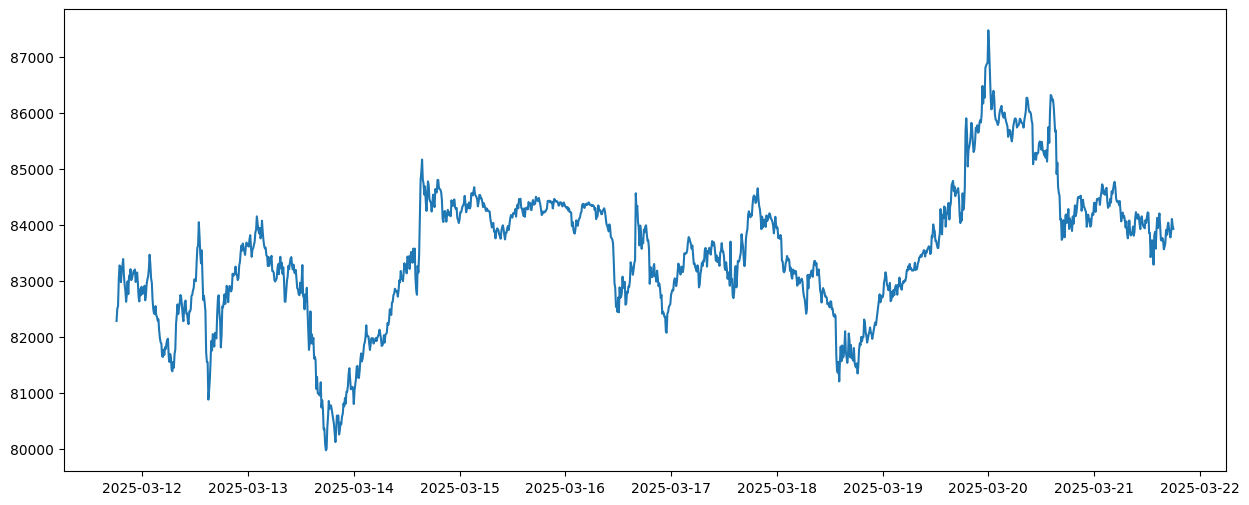

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(sub_data_[437]["timestamp"], sub_data_[437]["close"])

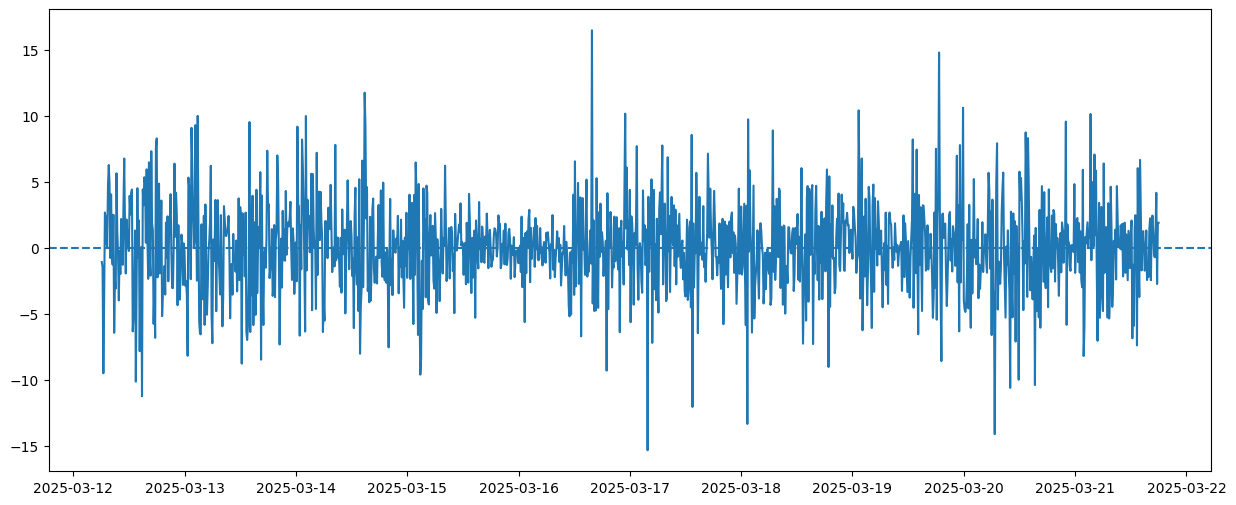

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(sub_data_[437]["timestamp"], sub_data_[437]["Moving Avg (Hour) Deriv"])
plt.axhline(0, linestyle="--")

In [ ]:
sub_data_

{437:        symbol                 timestamp        open        high           low  \
 0     BTC/USD 2025-03-11 18:10:00+00:00  81952.9000  82443.1270  81952.900000   
 1     BTC/USD 2025-03-11 18:20:00+00:00  82231.7060  82813.5445  82137.078376   
 2     BTC/USD 2025-03-11 18:30:00+00:00  82490.8665  82679.3230  82372.390000   
 3     BTC/USD 2025-03-11 18:40:00+00:00  82594.5400  83019.2375  82565.870000   
 4     BTC/USD 2025-03-11 18:50:00+00:00  82986.0365  83513.6000  82939.015500   
 ...       ...                       ...         ...         ...           ...   
 1433  BTC/USD 2025-03-21 17:20:00+00:00  83900.9070  83931.1290  83713.445000   
 1434  BTC/USD 2025-03-21 17:30:00+00:00  83828.0300  83876.2900  83708.146000   
 1435  BTC/USD 2025-03-21 17:40:00+00:00  83921.8280  84107.5590  83921.828000   
 1436  BTC/USD 2025-03-21 17:50:00+00:00  84046.8700  84073.7360  83982.900000   
 1437  BTC/USD 2025-03-21 18:00:00+00:00  83986.5430  84030.0725  83904.860500   
 
         

In [ ]:
shortest_trade = np.inf
key_shortest = 0
for key, value in orders_dict.items():
    time_diff = value["Sell Datetime"] - value["Order Datetime"]
    minutes = time_diff.total_seconds()/60
    if minutes < shortest_trade:
        shortest_trade = minutes
        key_shortest = key
print(f"Shortest: {shortest_trade} minutes, Key: {key_shortest}")

Shortest: 10.0 minutes, Key: 1


### Algorithm Parameter Optimization


In [ ]:
# resolution_optimal = 10  # minutes
# first_resolution_days = 1
# second_resolution_days = 5
# filter_length = 15
# cutoff = 0.20

# optimal_params = [
#     resolution_optimal,
#     first_resolution_days,
#     second_resolution_days,
#     filter_length,
#     cutoff,
# ]


# def optimize_algo(optimal_params, investment):

#     # if optimal_params[0] < 1:
#     #     return np.inf

#     # if optimal_params[1] < 1:
#     #     return np.inf

#     # if optimal_params[2] < 2:
#     #     return np.inf

#     # if optimal_params[3] < 3:
#     #     return np.inf

#     # if optimal_params[4] < 0:
#     #     return np.inf

#     # if optimal_params[2] < optimal_params[1]:
#     #     return np.inf

#     # Time Specifications for data
#     time_frame_optimal = TimeFrame(int(optimal_params[0]), TimeFrameUnit("Min"))
#     time_length = 30  # days
#     start_time = datetime.now() - timedelta(days=time_length)
#     end_time = datetime.now()
#     symbols = ["BTC/USD"]

#     # Creating request object
#     request_params = CryptoBarsRequest(
#         symbol_or_symbols=symbols,
#         timeframe=time_frame_optimal,
#         start=start_time,
#         end=end_time,
#     )

#     # Retrieve daily bars for Bitcoin in a DataFrame and printing it
#     btc_bars_optimal = client.get_crypto_bars(request_params)

#     # Convert to dataframe
#     btc_data_optimal = btc_bars_optimal.df.reset_index()

#     first_resolution = optimal_params[1] * int(60 / resolution_optimal) * 24  # minute
#     second_resolution = optimal_params[2] * int(60 / resolution_optimal) * 24  # minute

#     btc_data_optimal["Moving Avg (Hour)"] = (
#         btc_data_optimal["close"].rolling(int(first_resolution)).mean()
#     )
#     btc_data_optimal["Moving Avg (Hour) STD"] = (
#         btc_data_optimal["close"].rolling(int(first_resolution)).std()
#     )

#     btc_data_optimal["Moving Avg (Hour) Deriv"] = savgol_filter(
#         btc_data_optimal["Moving Avg (Hour)"],
#         window_length=int(optimal_params[3]),
#         polyorder=2,
#         deriv=1,
#     )

#     btc_data_optimal["Moving Avg (Day)"] = (
#         btc_data_optimal["close"].rolling(int(second_resolution)).mean()
#     )
#     btc_data_optimal["Moving Avg (Day) STD"] = (
#         btc_data_optimal["close"].rolling(int(second_resolution)).std()
#     )

#     _, _, investment = mean_reversion_crypto_algo(
#         btc_data, investment, deriv_cutoff=optimal_params[4]
#     )

#     return -investment


# res = minimize(optimize_algo, optimal_params, args=(investment), method="Nelder-Mead", options={"disp": True})
# res.x

In [ ]:
sub_data_

{437:        symbol                 timestamp        open        high           low  \
 0     BTC/USD 2025-03-11 18:10:00+00:00  81952.9000  82443.1270  81952.900000   
 1     BTC/USD 2025-03-11 18:20:00+00:00  82231.7060  82813.5445  82137.078376   
 2     BTC/USD 2025-03-11 18:30:00+00:00  82490.8665  82679.3230  82372.390000   
 3     BTC/USD 2025-03-11 18:40:00+00:00  82594.5400  83019.2375  82565.870000   
 4     BTC/USD 2025-03-11 18:50:00+00:00  82986.0365  83513.6000  82939.015500   
 ...       ...                       ...         ...         ...           ...   
 1433  BTC/USD 2025-03-21 17:20:00+00:00  83900.9070  83931.1290  83713.445000   
 1434  BTC/USD 2025-03-21 17:30:00+00:00  83828.0300  83876.2900  83708.146000   
 1435  BTC/USD 2025-03-21 17:40:00+00:00  83921.8280  84107.5590  83921.828000   
 1436  BTC/USD 2025-03-21 17:50:00+00:00  84046.8700  84073.7360  83982.900000   
 1437  BTC/USD 2025-03-21 18:00:00+00:00  83986.5430  84030.0725  83904.860500   
 
         

In [ ]:
import os
import smtplib
from io import BytesIO
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart

from dotenv import load_dotenv

load_dotenv()

# Email credentials
SMTP_SERVER = os.getenv("MAIL_SERVER")
SMTP_PORT = os.getenv("MAIL_PORT")
EMAIL_ADDRESS = os.getenv("MAIL_USERNAME")
EMAIL_PASSWORD = os.getenv("MAIL_PASSWORD")  # Use an App Password if using Gmail

fig = plt.figure(figsize=(15,6))
plt.plot(sub_data_[436]["timestamp"], sub_data_[436]["Moving Avg (Hour) Deriv"])
plt.axhline(0, linestyle="--")

tmpfile = BytesIO()
fig.savefig(tmpfile, format='png')

# Attach image
tmpfile.seek(0)
image_attachment = MIMEImage(tmpfile.read(), name="plot.png")

# Email details
recipient = os.getenv("RECIPIENT")
subject = "Test HTML Email"
html_content = """\
<html>
  <body>
    <h2>Hello, this is a test email!</h2>
    <p>This is an HTML email sent using Python.</p>
  </body>
</html>
"""

# Create message
msg = MIMEMultipart()
msg["From"] = EMAIL_ADDRESS
msg["To"] = recipient
msg["Subject"] = subject
msg.attach(MIMEText(html_content, "html"))
msg.attach(image_attachment)

# Send email
try:
    with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
        server.starttls()  # Secure connection
        server.login(EMAIL_ADDRESS, EMAIL_PASSWORD)
        server.sendmail(EMAIL_ADDRESS, recipient, msg.as_string())
    print("Email sent successfully!")
except Exception as e:
    print(f"Error: {e}")


KeyError: 436

<Figure size 1500x600 with 0 Axes>